In [1]:
import pandas
import numpy 
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

import tensorflow as tf
from tensorflow import keras

import plotly.io as pio
pio.renderers.default = "png"

2023-01-21 22:56:52.565476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 22:56:52.833110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 22:56:52.833137: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-21 22:56:52.872471: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-21 22:56:54.537191: W tensorflow/stream_executor/platform/de

In [2]:
df = pandas.read_csv("./data/train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
df["Order Date"] = pandas.to_datetime(df["Order Date"], infer_datetime_format=True)
df["Ship Date"] = pandas.to_datetime(df["Ship Date"], infer_datetime_format=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [5]:
# Identifying missing/null values

missing_values = df.isnull()
for cols in missing_values.columns:
    print(cols,': ', end="")
    print(missing_values[cols].value_counts())

Row ID : False    9800
Name: Row ID, dtype: int64
Order ID : False    9800
Name: Order ID, dtype: int64
Order Date : False    9800
Name: Order Date, dtype: int64
Ship Date : False    9800
Name: Ship Date, dtype: int64
Ship Mode : False    9800
Name: Ship Mode, dtype: int64
Customer ID : False    9800
Name: Customer ID, dtype: int64
Customer Name : False    9800
Name: Customer Name, dtype: int64
Segment : False    9800
Name: Segment, dtype: int64
Country : False    9800
Name: Country, dtype: int64
City : False    9800
Name: City, dtype: int64
State : False    9800
Name: State, dtype: int64
Postal Code : False    9789
True       11
Name: Postal Code, dtype: int64
Region : False    9800
Name: Region, dtype: int64
Product ID : False    9800
Name: Product ID, dtype: int64
Category : False    9800
Name: Category, dtype: int64
Sub-Category : False    9800
Name: Sub-Category, dtype: int64
Product Name : False    9800
Name: Product Name, dtype: int64
Sales : False    9800
Name: Sales, dtype: in

In [6]:
df.describe(include="all", datetime_is_numeric=True)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
count,9800.000000,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9789.000000,9800,9800,9800,9800,9800,9800.000000
unique,NaN,4922,NaN,NaN,4,793,793,3,1,529,49,NaN,4,1861,3,17,1849,NaN
top,NaN,CA-2018-100111,NaN,NaN,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN
freq,NaN,14,NaN,NaN,5859,35,35,5101,9800,891,1946,NaN,3140,19,5909,1492,47,NaN
mean,4900.500000,NaN,2017-04-12 14:24:35.265306368,2017-04-21 19:45:12.489796096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55273.322403,NaN,NaN,NaN,NaN,NaN,230.769059
min,1.000000,NaN,2015-01-02 00:00:00,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000
25%,2450.750000,NaN,2016-05-02 12:00:00,2016-05-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.248000
50%,4900.500000,NaN,2017-05-30 00:00:00,2017-06-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58103.000000,NaN,NaN,NaN,NaN,NaN,54.490000
75%,7350.250000,NaN,2018-04-11 00:00:00,2018-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,210.605000
max,9800.000000,NaN,2018-12-30 00:00:00,2019-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99301.000000,NaN,NaN,NaN,NaN,NaN,22638.480000


In [7]:
size_by_state = df["State"].value_counts().to_frame()
size_by_state.reset_index(inplace=True)
size_by_state.columns = ["States", "Counts"]
size_by_state.sort_values(by="Counts", ascending=False, inplace=True)

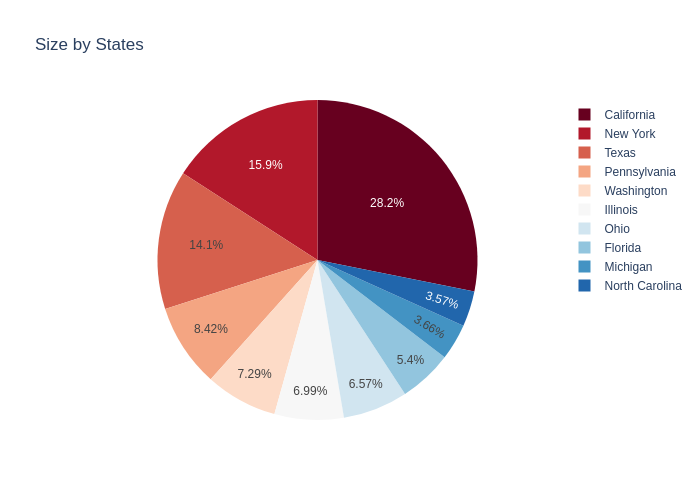

In [8]:

fig = px.pie(size_by_state[:10], 
             values='Counts', 
             names='States', 
             title='Size by States',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

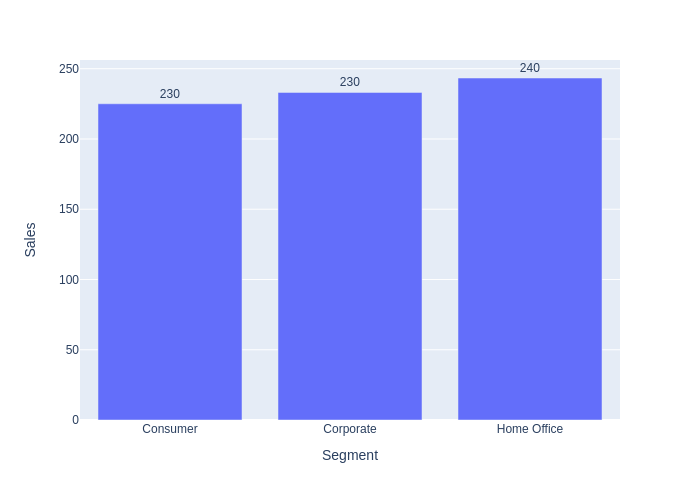

In [9]:
sales_by_segment = df.groupby("Segment")["Sales"].mean().to_frame()
sales_by_segment.reset_index(inplace=True)

fig = px.bar(sales_by_segment,
            x="Segment",
            y="Sales",
            text="Sales")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [10]:
segement_by_category = df.groupby(["Segment", "Sub-Category"])["Sales"].sum().to_frame()
segement_by_category.reset_index(inplace=True)

In [11]:
segement_by_category.head()

,Segment,Sub-Category,Sales
0,Consumer,Accessories,85699.074
1,Consumer,Appliances,52367.233
2,Consumer,Art,14062.256
3,Consumer,Binders,117091.909
4,Consumer,Bookcases,67949.397


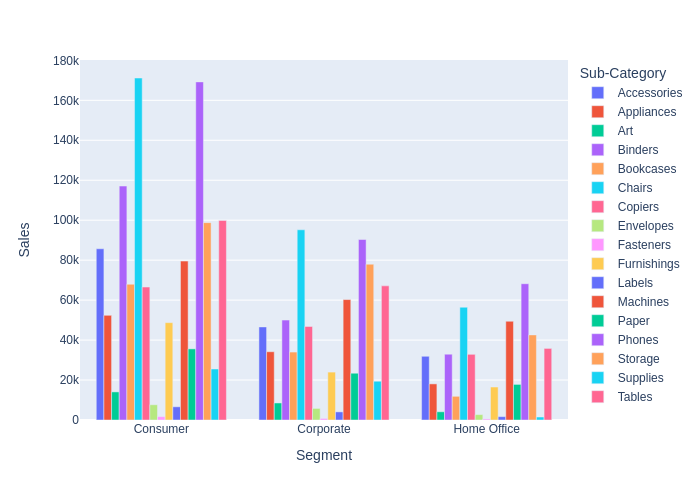

In [12]:
fig = px.bar(segement_by_category,
            x="Segment",
            y="Sales",
            barmode="group",
            color="Sub-Category")
fig.show()

In [13]:
ordertime_by_sales = df[["Order Date", "Sales"]]
ordertime_by_sales.set_index(keys="Order Date", inplace=True)

In [14]:
order_per_day = ordertime_by_sales.resample("D").sum()

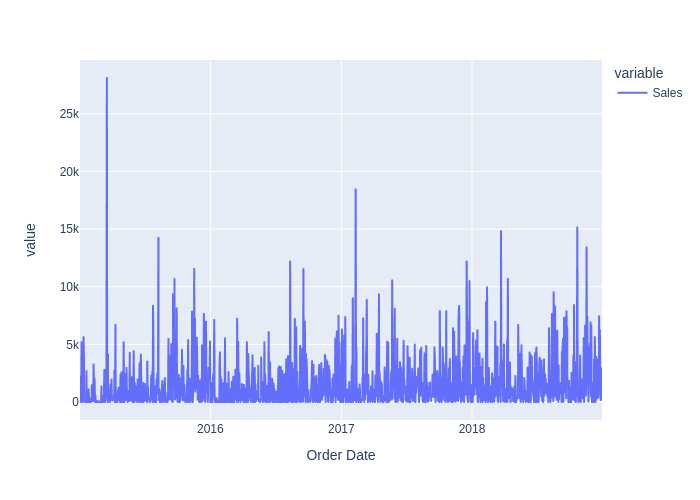

In [15]:
fig = px.line(order_per_day)
fig.show()

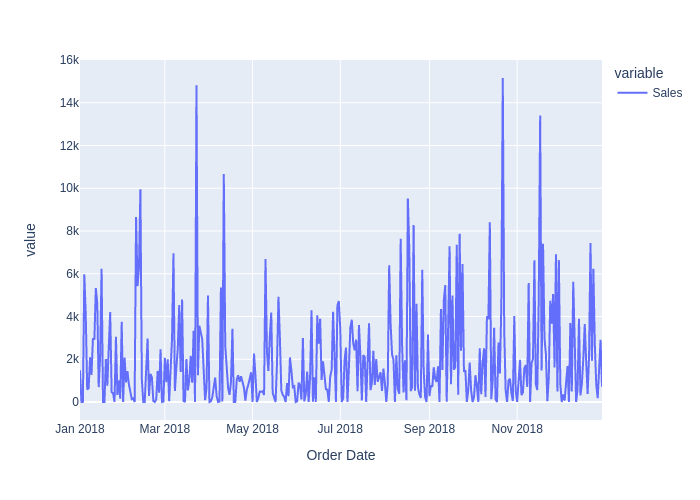

In [16]:
fig = px.line(order_per_day.loc["2018"])
fig.show()

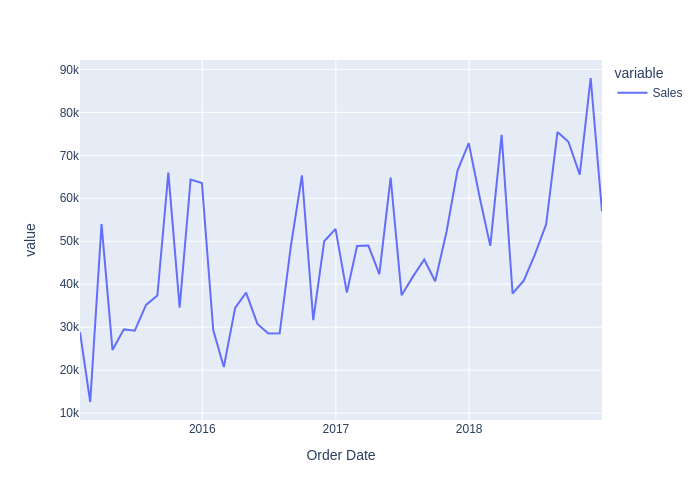

In [17]:
order_per_Month = ordertime_by_sales.resample("M").sum()
fig = px.line(order_per_Month)
fig.show()

In [18]:
df["order_year"] = df["Order Date"].dt.year
df["order_month"] = df["Order Date"].dt.month
df["order_wek"] = df["Order Date"].dt.isocalendar().week

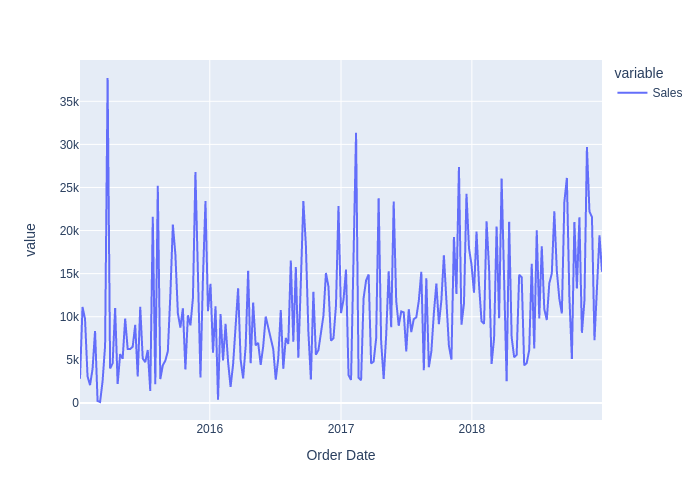

In [19]:
order_per_week = ordertime_by_sales.resample("W").sum()
fig = px.line(order_per_week)
fig.show()

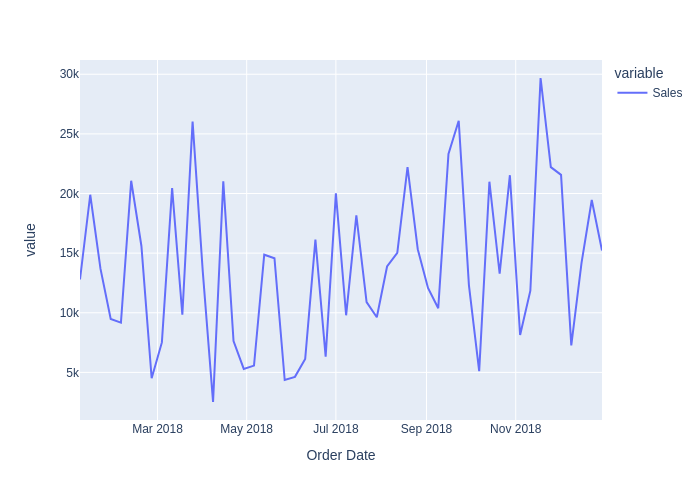

In [20]:
order_by_year = ordertime_by_sales.resample("W").sum()
fig = px.line(order_by_year.loc["2018"])
fig.show()

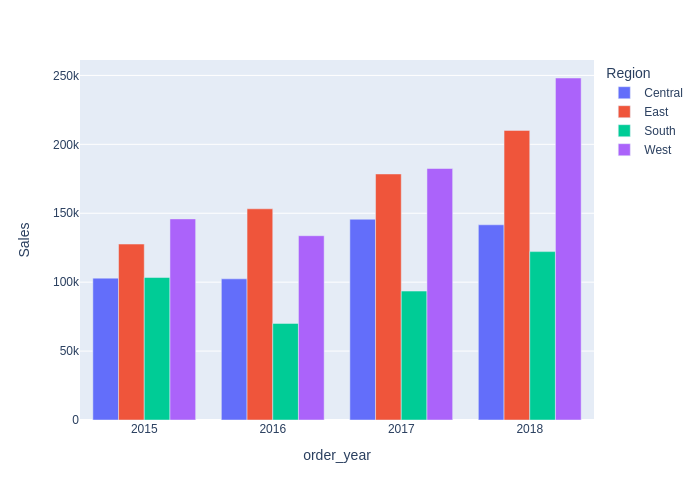

In [21]:
sales_by_region = df.groupby(["order_year", "Region"])["Sales"].sum().to_frame()
sales_by_region.reset_index(inplace=True)
fig = px.bar(sales_by_region,
            x="order_year",
            y="Sales",
            barmode="group",
            color="Region")
fig.show()

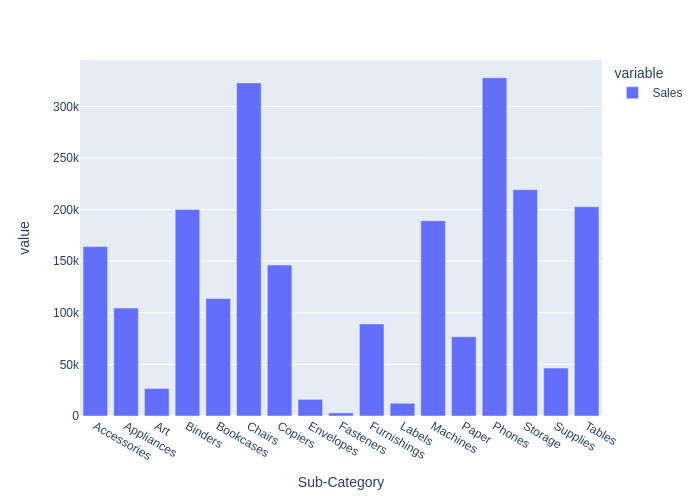

In [22]:
sales_by_subcat = df.groupby("Sub-Category")["Sales"].sum()
fig = px.bar(sales_by_subcat)
fig.show()

In [23]:
counts_by_subcat = df["Sub-Category"].value_counts().to_frame()
counts_by_subcat.reset_index(inplace=True)
counts_by_subcat.columns = ["Sub-Category", "Frequency"]

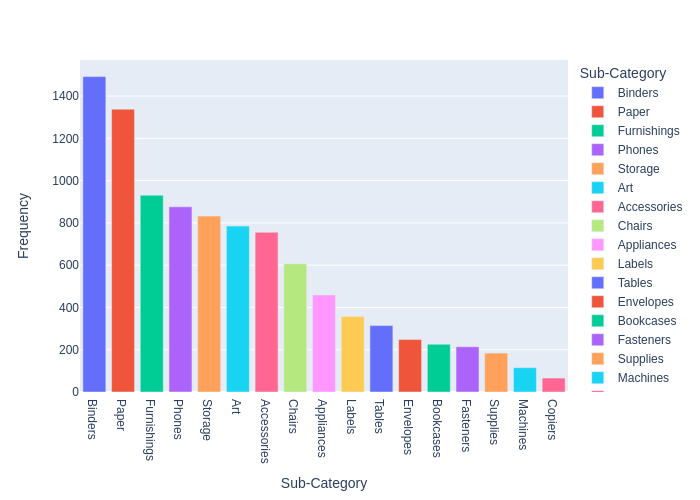

In [24]:
fig = px.bar(counts_by_subcat, 
             x='Sub-Category', 
             y='Frequency',
             color='Sub-Category')
fig.show()

In [25]:
counts_by_cat = df["Category"].value_counts().to_frame()
counts_by_cat.reset_index(inplace=True)
counts_by_cat.columns = ["Category", "Frequency"]

In [26]:
counts_by_cat

,Category,Frequency
0,Office Supplies,5909
1,Furniture,2078
2,Technology,1813


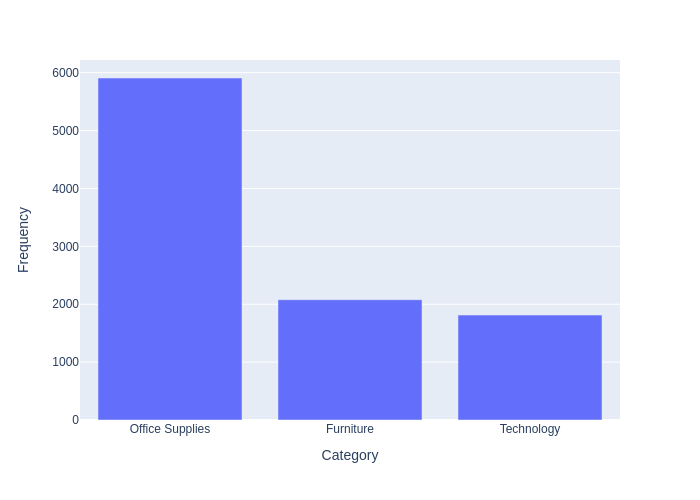

In [27]:
fig = px.bar(counts_by_cat, 
             x='Category', 
             y='Frequency'
             )
fig.show()

### Model Development

In [28]:
order_per_week = order_per_day.copy()
order_per_week.fillna(0, inplace=True)
train_size = int(len(order_per_week) * 0.7)
train_set = order_per_week[: train_size]
test_set = order_per_week[train_size:]

In [29]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1021 entries, 2015-01-02 to 2017-10-18
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   1021 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 438 entries, 2017-10-19 to 2018-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   438 non-null    float64
dtypes: float64(1)
memory usage: 6.8 KB


(None, None)

In [30]:
train_set.shape, test_set.shape

((1021, 1), (438, 1))

### Naive Model

Building a persistence model this will identify a base error for subsequent Models

In [31]:
def naive_model(history):
    return history[-1]

In [32]:
def forecast_model(model, X:pandas.DataFrame, y: pandas.DataFrame):
    predictions = list()
    history = [x for x in X.values]
    for p in range(len(y.values)):
        yhat = model(history=history)
        predictions.append(yhat)
        history.append(y.values[p])
    rmse = numpy.sqrt(mean_squared_error(y.values, predictions))
    return rmse, predictions

In [33]:
rmse, naive_predictions = forecast_model(model=naive_model, X=train_set, y=test_set)

In [34]:
rmse

3264.087940027748

In [35]:
naive_predictions = numpy.array(naive_predictions)

In [36]:
naive_predictions = naive_predictions.reshape((naive_predictions.shape[0],))
naive_predictions.shape

(438,)

In [37]:
naive_test = test_set.copy()
naive_test.loc[:,"naive"] = naive_predictions

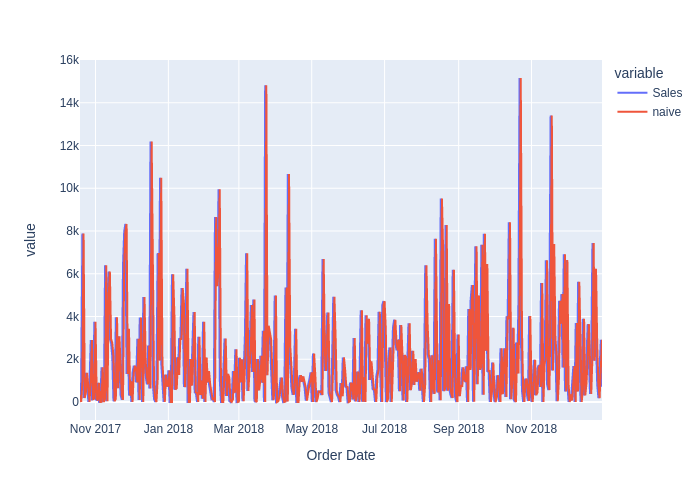

In [38]:
fig = px.line(naive_test)
fig.show()

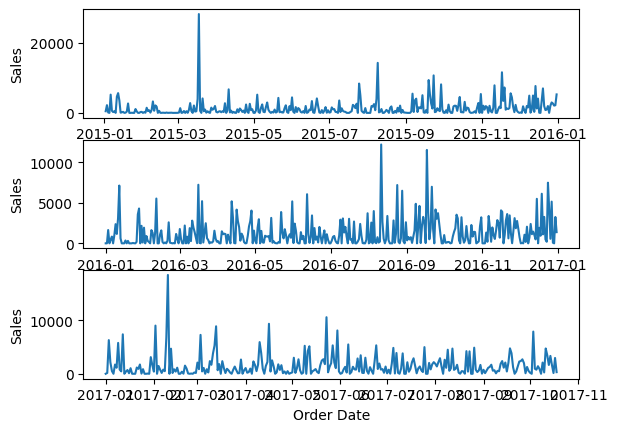

In [39]:
groups = train_set.Sales['2015':'2017'].groupby(pandas.Grouper(freq='A'))
years = pandas.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    seaborn.lineplot(group)
plt.show()

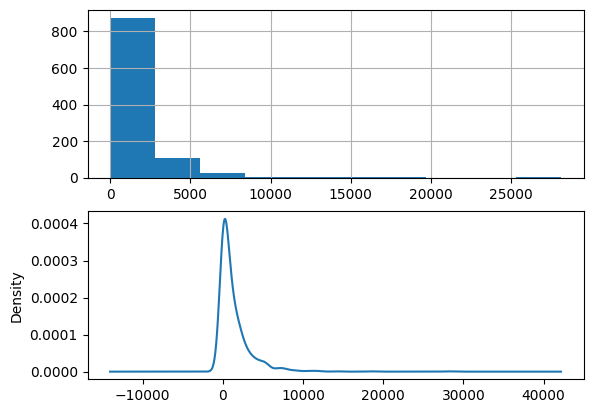

In [40]:
plt.figure(1)
plt.subplot(211)
train_set.Sales.hist()
plt.subplot(212)
train_set.Sales.plot(kind='kde')
plt.show()

In [41]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pandas.Series(diff)

def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

In [42]:
train_df = train_set.squeeze()
train_df = train_df.values
train_df = train_df.astype("float32")

test_df = test_set.squeeze()
test_df = test_df.values
test_df = test_df.astype("float32")

In [43]:
day_in_year = 365
stationary = difference(train_df, day_in_year)

ADF Statistic: -20.412475
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


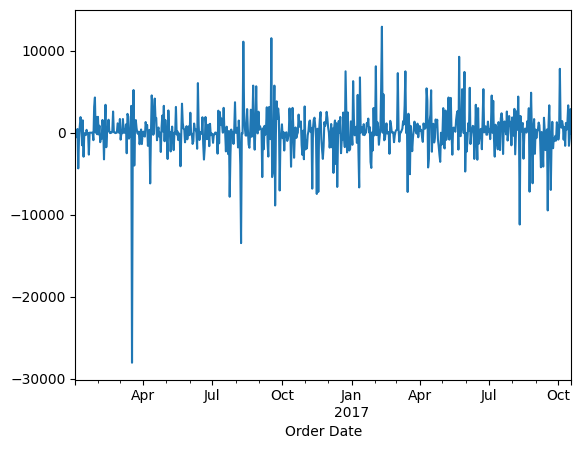

In [44]:
day_in_year = 365
stationary = difference(train_df, day_in_year)
stationary.index = train_set.index[day_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
plt.show()

/home/vhyne/anaconda3/envs/TF-py/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



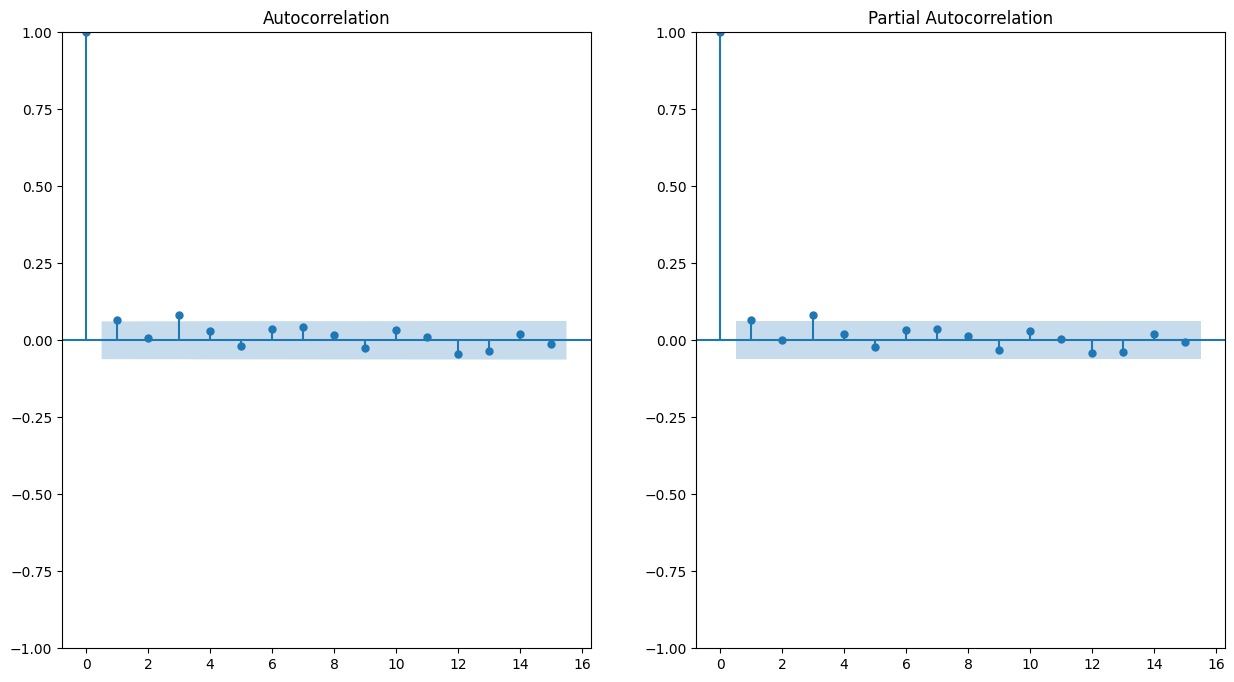

In [45]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plot_acf(train_df, lags=15, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(train_df, lags=15, ax=plt.gca())
plt.show()

In [46]:
test_df.shape, train_df.shape

((438,), (1021,))

In [47]:
def arima_forecast(history):
    history = numpy.array(history)
    history = history.reshape((history.shape[0],))
    stationary = difference(history, day_in_year)
    arima_model = ARIMA(stationary, order=(1,0,1))
    arima_model_fit = arima_model.fit()
    yhat = arima_model_fit.forecast()
    yhat = inverse_difference(history, yhat, day_in_year)
    return yhat

In [48]:
# history = [x for x in train_set.values]
# history = numpy.array(history)
# history = history.astype("float32")
# history = history.reshape((history.shape[0],))

# arima_predictions = list()
# history = [x for x in train_df]
# for p in range(len(test_df)):
#     stationary = difference(history, day_in_year)
#     arima_model = ARIMA(stationary, order=(1,0,1))
#     arima_model_fit = arima_model.fit()
#     yhat = arima_model_fit.forecast()
#     yhat = inverse_difference(history, yhat, 52)
#     arima_predictions.append(yhat.values)
#     history.append(test_df[p])
# rmse = numpy.sqrt(mean_squared_error(test_df, arima_predictions))

In [49]:
rmse, arima_predictions = forecast_model(model=arima_forecast, X=train_set, y=test_set)

In [50]:
rmse

3063.065202348473

In [51]:
arima_predictions = numpy.array(arima_predictions)
arima_predictions = arima_predictions.reshape((arima_predictions.shape[0],))

In [52]:
arima_predictions.shape

(438,)

In [53]:
arima_test = test_set.copy()
arima_test.loc[:,"arima"] = arima_predictions

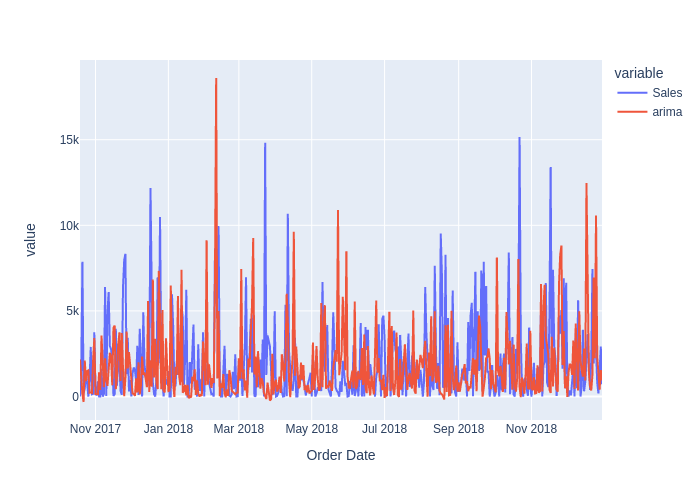

In [54]:
fig = px.line(arima_test)
fig.show()

In [55]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(train_set['Sales'], autolag='AIC')

dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.654920e+01
p-value                        1.952041e-29
#Lags Used                     2.000000e+00
Number of Observations Used    1.018000e+03
Critical Value (1%)           -3.436790e+00
Critical Value (5%)           -2.864383e+00
Critical Value (10%)          -2.568284e+00
dtype: float64


In [56]:
ARIMA_model = pm.auto_arima(train_set['Sales'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

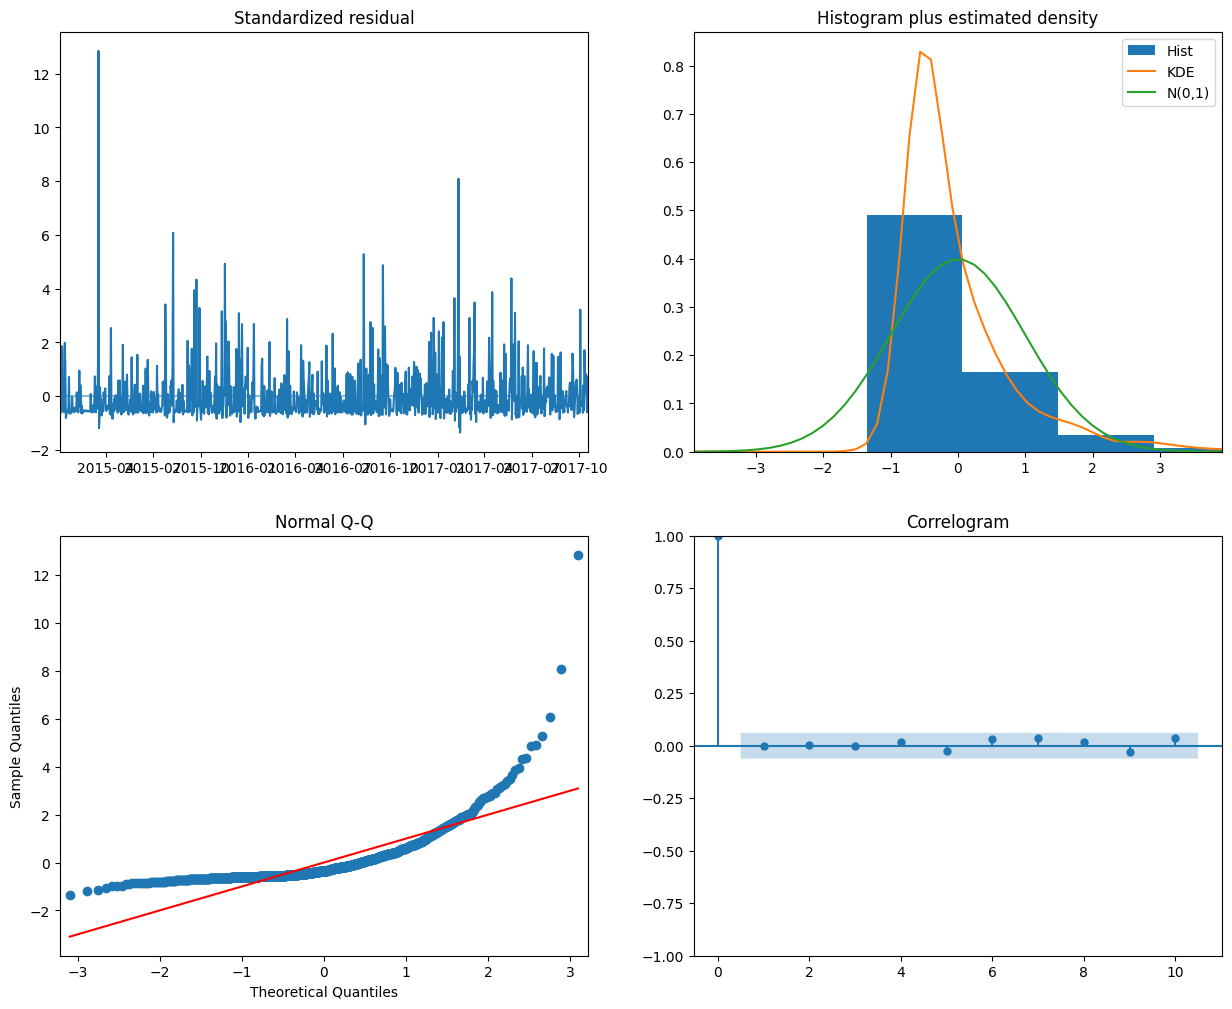

In [57]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [58]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pandas.date_range(train_set.index[-1] + pandas.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pandas.Series(fitted, index=index_of_fc)
    lower_series = pandas.Series(confint[:, 0], index=index_of_fc)
    upper_series = pandas.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train_set["Sales"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Sales For SuperStore")
    plt.show()
    return fitted

# fitted = forecast(ARIMA_model)

In [59]:
SARIMA_model = pm.auto_arima(train_set["Sales"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=3, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

## Univariate LSTM

In [60]:
daily_sales = order_per_day.resample("D").sum()
daily_sales.fillna(0, inplace=True)

In [61]:
train_x = daily_sales.loc["2015-01-04": "2017-12-30"]
val_x = daily_sales.loc["2017-12-31": "2018-12-29"]
train_x = numpy.array(numpy.split(train_x, (len(train_x)/7)))
val_x = numpy.array(numpy.split(val_x, (len(val_x)/7)))

In [62]:
train_x.shape, val_x.shape

((156, 7, 1), (52, 7, 1))

In [63]:
def reshape_nn_input(x: numpy, n_input: int, n_output):
    data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    X, y = list(), list()
    first_index = 0
    for _ in range(len(data)):
        in_len = first_index + n_input
        target_len = in_len + n_output
        if target_len <= len(data):
            x_input = data[first_index:in_len, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_len:target_len, 0])
        first_index += 1
    return numpy.array(X), numpy.array(y)

In [64]:
x_train, y_train = reshape_nn_input(x=train_x, n_input=21, n_output=7)
x_train.shape, y_train.shape

((1065, 21, 1), (1065, 7))

In [65]:
def lstm_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.LSTM(100, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.Dense(50, activation=keras.activations.relu))
    model.add(keras.layers.Dense(10, activation=keras.activations.relu))
    model.add(keras.layers.Dense(num_outputs))

    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=50, batch_size=16, verbose=2)
    return history, model

In [66]:
history, model = lstm_model(x=x_train, y=y_train)

2023-01-21 22:58:28.275829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-21 22:58:28.275861: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-21 22:58:28.275884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vhyne): /proc/driver/nvidia/version does not exist
2023-01-21 22:58:28.276198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
67/67 - 2s - loss: 5960421.5000 - 2s/epoch - 34ms/step
Epoch 2/50
67/67 - 1s - loss: 5065869.5000 - 735ms/epoch - 11ms/step
Epoch 3/50
67/67 - 1s - loss: 5025287.5000 - 850ms/epoch - 13ms/step
Epoch 4/50
67/67 - 1s - loss: 5021915.5000 - 605ms/epoch - 9ms/step
Epoch 5/50
67/67 - 1s - loss: 5132033.0000 - 603ms/epoch - 9ms/step
Epoch 6/50
67/67 - 1s - loss: 5109176.5000 - 604ms/epoch - 9ms/step
Epoch 7/50
67/67 - 1s - loss: 5105431.5000 - 627ms/epoch - 9ms/step
Epoch 8/50
67/67 - 1s - loss: 5195255.5000 - 606ms/epoch - 9ms/step
Epoch 9/50
67/67 - 1s - loss: 5231927.0000 - 596ms/epoch - 9ms/step
Epoch 10/50
67/67 - 1s - loss: 5259446.5000 - 606ms/epoch - 9ms/step
Epoch 11/50
67/67 - 1s - loss: 5176503.5000 - 598ms/epoch - 9ms/step
Epoch 12/50
67/67 - 1s - loss: 5023560.5000 - 773ms/epoch - 12ms/step
Epoch 13/50
67/67 - 1s - loss: 5117097.0000 - 764ms/epoch - 11ms/step
Epoch 14/50
67/67 - 1s - loss: 5058456.0000 - 639ms/epoch - 10ms/step
Epoch 15/50
67/67 - 1s - loss: 4999078.5

In [67]:
train_x[-3:].shape

(3, 7, 1)

In [68]:
def model_prediction(model, x: numpy, n_inputs=3):
    # data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    # print(data.shape)

    last_week = x[-n_inputs:]
    last_week = last_week.reshape((1,last_week.shape[0] * last_week.shape[1], 1))
    print(last_week.shape)
    yhat = model.predict(last_week, verbose=1)

    return yhat

In [69]:
yhat = model_prediction(model=model, x=train_x)
yhat

(1, 21, 1)
1/1 [==============================] - 0s 173ms/step


array([[2145.436 , 2255.394 , 2216.418 , 2075.6355, 2297.4082, 2116.841 ,
        2344.938 ]], dtype=float32)

In [70]:
x_history = [x for x in train_x]
x_history = numpy.array(x_history)
x_history.shape

(156, 7, 1)

In [90]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[2]
    return numpy.reshape(array, (array_multiplication,))

In [81]:
def model_prediction(model, x: numpy, n_inputs=3):
    data = numpy.array(x)

    last_week = data[-n_inputs:]
    last_week = last_week.reshape((1,last_week.shape[0] * last_week.shape[1], 1))
    yhat = model.predict(last_week, verbose=0)

    return yhat

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    return predictions

In [82]:
predictions_lstm = evaluate_model(model=model, train=train_x, test=val_x)

In [83]:
predictions_lstm.shape

(52, 1, 7)

In [91]:
pred_lstm_flatten = flatten_shape(predictions_lstm)

In [85]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[1]
    return numpy.reshape(array, (array_multiplication,))

val_flatten = flatten_shape(val_x)

In [86]:
rmse_lstm = numpy.sqrt(mean_squared_error(val_flatten, pred_lstm_flatten))
rmse_lstm

2419.9552772861725

In [87]:
daily_sales_date = daily_sales.loc["2017-12-31": "2018-12-29"].copy()
daily_sales_date.reset_index(inplace=True)

In [88]:
lstm_pred_frame = pandas.DataFrame({"Date":daily_sales_date["Order Date"], "Pred": pred_lstm_flatten, "True": val_flatten})
lstm_pred_frame.set_index(keys="Date", inplace=True)

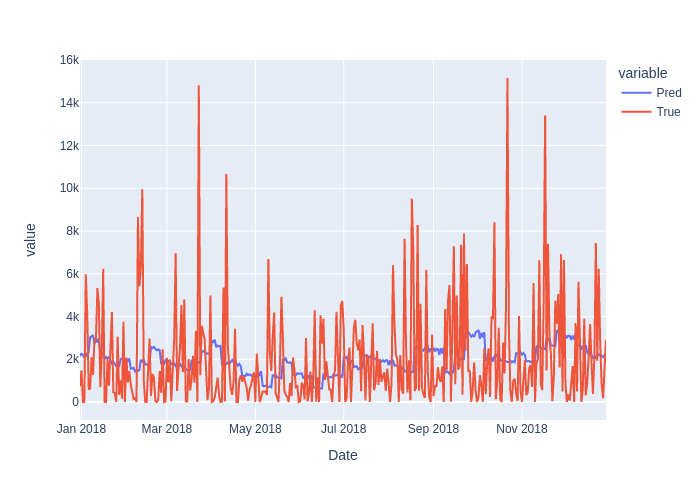

In [89]:
fig = px.line(lstm_pred_frame)
fig.show()